---------------------------------------------------------------------
## Data Science with Python
### Task 3: Build and Evaluate Models
#### By Roslyn Badilla
#### March, 2020
---------------------------------------------------------------------

In [113]:
#imports
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt

#estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier

#model metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

#cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [41]:
#data
rawData = pd.read_csv('credit_clean.csv', header=0)

In [42]:
# Decode data in AGE_GROUP(Quantile bins) to be a number:

def age_group1(series):
    if series == "(20.999, 27.0]":
        return "1"
    elif series == "(27.0, 31.0]":
        return "2"
    elif series == "(31.0, 37.0]":
        return "3"
    elif series == "(37.0, 43.0]":
        return "4" 
    elif series == "(43.0, 79.0]":
        return "5"

rawData['AGE_GROUP'] = rawData['AGE_GROUP'].apply(age_group1)

rawData['AGE_GROUP'].value_counts(sort=False) 

4    5056
3    6728
2    5626
5    5986
1    6604
Name: AGE_GROUP, dtype: int64

In [43]:
# Decode data in CREDIT_GROUP(6 bins) to be a number:

def credit_group(series):
    if series == "(9010.0, 175000.0]":
        return "1"
    elif series == "(175000.0, 340000.0]":
        return "2"
    elif series == "(340000.0, 505000.0]":
        return "3"
    elif series == "(505000.0, 670000.0]":
        return "4" 
    elif series == "(670000.0, 835000.0]":
        return "5"
    elif series == "(835000.0, 1000000.0]":
        return "6" 
 
rawData['CREDIT_GROUP'] = rawData['CREDIT_GROUP'].apply(credit_group)

rawData['CREDIT_GROUP'].value_counts(sort=False) 

4      170
3     3382
6        1
2     8786
5       35
1    17626
Name: CREDIT_GROUP, dtype: int64

#### 1-Selecting features for Classification
In the last code I cleaned and grouped some columns like Marriage, Education and Limit_bal.
Checking correlations I found that most of Bill_AMT features are correlated. So I'm going to create 2 dataset with distinct features to test which one performs better.

In [47]:
features1 = ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'PAY_0','PAY_2', 'PAY_3', 
            'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT4', 'PAY_AMT1',
            'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 
            'AGE_GROUP','IS_FEMALE']

features2 = ['EDUCATION', 'MARRIAGE', 'PAY_0','PAY_2', 'PAY_3', 
            'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT4', 'PAY_AMT1',
            'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 
            'AGE_GROUP', 'IS_FEMALE', 'CREDIT_GROUP']

#### 2. Select the Dependent Variable

In [48]:
y = rawData['DEFAULT'].copy()

#### 3. Select independent features -  X-variables

In [49]:
X1 = rawData[features1].copy()
X2 = rawData[features2].copy()

#### 4. Establish the training sets and Testing sets (70/30)
Both sets are going to be tested in the same Algorithms. 

In [50]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.30, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.30, random_state=42)

In [51]:
X1_train.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT4,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,AGE_GROUP,IS_FEMALE
28465,240000,1,1,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,4,1
27622,50000,1,2,-1,-1,-1,-1,-1,-1,3430,4800,2548,2321,4800,9810,660,2980,1,1
28376,50000,2,1,2,2,2,2,0,0,46203,47956,0,4700,0,2004,3500,0,3,1
10917,200000,3,1,6,5,4,3,2,2,110185,102549,0,0,0,0,0,0,5,1
27234,240000,1,1,-1,-1,-1,0,-1,-1,2024,17102,2017,21817,1120,13434,22772,22820,3,0


In [13]:
X2_train.head()

,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT4,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,AGE_GROUP2,IS_FEMALE,CREDIT_GROUP
28465,1,1,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,"(32.6, 44.2]",1,"(175000.0, 340000.0]"
27622,1,2,-1,-1,-1,-1,-1,-1,3430,4800,2548,2321,4800,9810,660,2980,"(20.942, 32.6]",1,"(9010.0, 175000.0]"
28376,2,1,2,2,2,2,0,0,46203,47956,0,4700,0,2004,3500,0,"(32.6, 44.2]",1,"(9010.0, 175000.0]"
10917,3,1,6,5,4,3,2,2,110185,102549,0,0,0,0,0,0,"(44.2, 55.8]",1,"(175000.0, 340000.0]"
27234,1,1,-1,-1,-1,0,-1,-1,2024,17102,2017,21817,1120,13434,22772,22820,"(32.6, 44.2]",0,"(175000.0, 340000.0]"


## Algorithm Selection
### Random Forest Classifier

In [52]:
modelRF= RandomForestClassifier()

#### X1 Data Set

In [68]:
modelRF.fit(X1_train,y1_train)
print(cross_val_score(modelRF, X1_train, y1_train))
modelRF.score(X1_train,y1_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.80802742 0.80528571 0.80240034]


0.9788095238095238

#### X2 Data Set

In [69]:
modelRF.fit(X2_train,y2_train)
print(cross_val_score(modelRF, X2_train, y2_train))
modelRF.score(X2_train,y2_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.80459934 0.802      0.80382912]


0.974047619047619

### Ada Boost Classifier

In [61]:
modelADA = AdaBoostClassifier()

#### X1 Dataset

In [63]:
modelADA.fit(X1_train,y1_train)
print(cross_val_score(modelADA, X1_train, y1_train))
modelADA.score(X1_train,y1_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.82302528 0.81428571 0.81625947]


0.8189047619047619

#### X2 Dataset

In [64]:
modelADA.fit(X2_train,y2_train)
print(cross_val_score(modelADA, X2_train, y2_train))
modelADA.score(X2_train,y2_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.82288245 0.81314286 0.81483069]


0.817952380952381

### Gradient Boost Classifier

In [65]:
modelGBC = GradientBoostingClassifier()

#### X1 Dataset

In [66]:
modelGBC.fit(X1_train,y1_train)
print(cross_val_score(modelGBC, X1_train, y1_train))
modelGBC.score(X1_train,y1_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.82445365 0.81871429 0.81840263]


0.8275714285714286

#### X2 Dataset

In [67]:
modelGBC.fit(X2_train,y2_train)
print(cross_val_score(modelGBC, X2_train, y2_train))
modelGBC.score(X2_train,y2_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.82531067 0.81842857 0.81925989]


0.8272857142857143

## Tunning Selected Model
The model with best performance is RANDOM FOREST with dataset X1. So, next step is to tune the parameters

In [76]:
#Create a grid for tunning
param_grid = {'n_estimators': [200, 400], 
              'criterion': ['entropy', 'gini'],
              'class_weight' : ['balanced'], 'n_jobs' : [-1]} #use all the computational CPU

grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

%time grid_forest = grid_forest.fit(X1_train, y1_train)

print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
modelRF_tuned = grid_forest.best_estimator_

Wall time: 2min 30s
RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.8167619047619048


In [79]:
modelRF_tuned.score(X1_train,y1_train)

0.9975714285714286

## Making Predictions

In [97]:
#Make Predictions
predictions = modelRF_tuned.predict(X1_test)
accuracy = accuracy_score(y_true = y1_test, y_pred = predictions)
f1_sc = f1_score(y_true = y1_test, y_pred = predictions)
print('Accuracy: %.3f' % accuracy)
print('f1_Score: %.3f' % f1_sc)

Accuracy: 0.812
f1_Score: 0.447


## Final accuracy: 0.812

In [102]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feat':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

get_feature_importance(modelRF_tuned, features1)

,feat,score
9,BILL_AMT1,0.094701
3,PAY_0,0.083647
0,LIMIT_BAL,0.083057
10,BILL_AMT4,0.079949
11,PAY_AMT1,0.077221
12,PAY_AMT2,0.073816
13,PAY_AMT3,0.069306
16,PAY_AMT6,0.068788
14,PAY_AMT4,0.068209
15,PAY_AMT5,0.066114


## Ploting Results

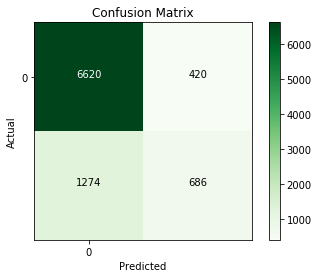

In [155]:
cf =confusion_matrix(y1_test ,predictions)

import itertools 

plt.imshow(cf,cmap=plt.cm.Greens,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y1_test))-1) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)

# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

## Conclusions:
#### Our final Accuracy was 81% which is not bad for another kind of predictions but in the case of detecting Default Clients it needs to improve, I recommend to find more features and create more variables from the data CreditOne has, and continue testing.